<a href="https://colab.research.google.com/github/webbigdata-jp/python_sample/blob/main/Stable_Diffusion_2_1_base512_DreamBooth_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 無料版ColabでStable Diffusion 2.1 Base Model(512版)をDream Boothで微調整するためのシンプルなColabファイル

Stable Diffusion 2.1が出たので以前公開していた2.0版を2.1版に差し替えました。

まずは左上の「ファイル」メニューより「ドライブにコピーを保存」を選んで、本ファイルをご自分のGoogleドライブ上にコピーして保存し、コピーした方のファイルをブックマークしてください。


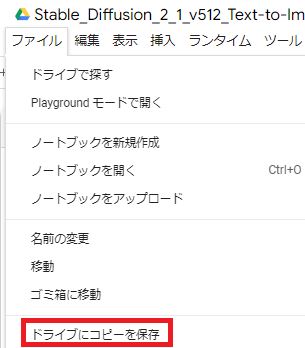

自分用に保存しておけば仮にファイルを壊してしまっても、もう一度コピーしてやり直す事ができます。  

なお、保存時に以下のような警告ウィンドウがでる事がありますが、本ファイルが信用できると思った場合は「このまま実行」を押してください。

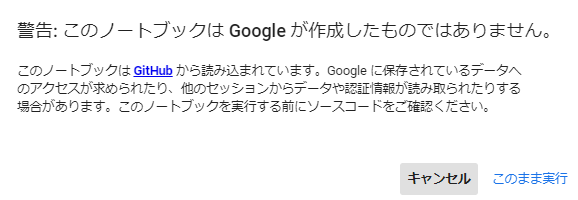


その後、左下の方に表示されている以下のマークを順番にクリックしていってください。

mark.png

１～５は起動毎に一度だけ押せば大丈夫です。６と７はプロンプトを変更する度に押す必要があります。

In [8]:
#@title １．必要なライブラリのインストール
%%capture
%%shell
git clone https://github.com/huggingface/diffusers.git
pip install --upgrade git+https://github.com/huggingface/diffusers.git
pip install --upgrade diffusers[torch]
pip install -q accelerate transformers ftfy bitsandbytes gradio natsort datasets bitsandbytes
pip install --upgrade --pre triton
cd /content/diffusers/examples/dreambooth

In [2]:
%%capture
%%shell

#@title ２．Stable Diffusion 2.1モデルのダウンロード

#@markdown モデルは大きい(5Gバイト)のでダウンロードには５分近くの時間がかかる事があります。丁寧な作りになっているColabファイルでは毎回ダウンロードしなくて済むようにGoogle Driveにモデルを保存する作りになっている事があります。  

#@markdown しかし、Google Driveに保存するためには「Google Driveへの権限を与えても良いですか？」と表示されるウインドウに対して承認を行うステップが増えます。  

#@markdown 初心者には何か良く分からないウインドウに対して承認を押すのはハードルが上がると思うので毎回ダウンロードする作りにしています。  

#@markdown ライセンス等の使用条件は[配布サイト](https://huggingface.co/stabilityai/stable-diffusion-2-1)で確認してください。

mkdir stable-diffusion-2-1-base
cd stable-diffusion-2-1-base
wget https://huggingface.co/stabilityai/stable-diffusion-2-1-base/raw/main/model_index.json

mkdir vae
cd vae
wget https://huggingface.co/stabilityai/stable-diffusion-2-1-base/raw/main/vae/config.json
wget https://huggingface.co/stabilityai/stable-diffusion-2-1-base/resolve/main/vae/diffusion_pytorch_model.bin

cd ..

mkdir unet
cd unet
wget https://huggingface.co/stabilityai/stable-diffusion-2-1-base/raw/main/unet/config.json
wget https://huggingface.co/stabilityai/stable-diffusion-2-1-base/resolve/main/unet/diffusion_pytorch_model.bin
cd ..

mkdir tokenizer
cd tokenizer
wget https://huggingface.co/stabilityai/stable-diffusion-2-1-base/raw/main/tokenizer/merges.txt
wget https://huggingface.co/stabilityai/stable-diffusion-2-1-base/raw/main/tokenizer/special_tokens_map.json
wget https://huggingface.co/stabilityai/stable-diffusion-2-1-base/raw/main/tokenizer/vocab.json
wget https://huggingface.co/stabilityai/stable-diffusion-2-1-base/raw/main/tokenizer/tokenizer_config.json
cd ..

mkdir text_encoder
cd text_encoder
wget https://huggingface.co/stabilityai/stable-diffusion-2-1-base/raw/main/text_encoder/config.json
wget https://huggingface.co/stabilityai/stable-diffusion-2-1-base/resolve/main/text_encoder/pytorch_model.bin
cd ..

mkdir scheduler
cd scheduler
wget https://huggingface.co/stabilityai/stable-diffusion-2-1-base/raw/main/scheduler/scheduler_config.json
cd ..

mkdir feature_extractor
cd feature_extractor
wget https://huggingface.co/stabilityai/stable-diffusion-2-1-base/raw/main/feature_extractor/preprocessor_config.json
cd ..

cd ..


In [33]:
#@title ３．プロンプトの設定

#@markdown 取り込む画像の種類を設定します。今回は愛犬を前提なのでdogとします。  
#@markdown 愛猫の写真を使いたい場合はcatに修正してください。

class_name = "dog" #@param {type:"string"}

#@markdown 取り込む画像に仮の名前をつけます。  
#@markdown 後程、プロンプト内でこの単語を使って学習した概念を指定可能になります。  
#@markdown 愛猫の写真を使いたい場合はwajの部分は特に変更不要でdogをcatに修正してください。  

instance_name = "waj dog" #@param {type:"string"}


In [36]:
#@title ４．学習用画像のアップロード
%%capture

#@markdown 学習用画像をアップロードします。  
#@markdown 今回の例は犬の画像を差し替えるので愛犬の画像を３～５枚程度アップロードしてください。 
#@markdown 画像サイズは可能なら512 x 512に揃えると品質の良い画像ができます  

INSTANCE_DIR = "/content/data/instance-images"
!mkdir -p $INSTANCE_DIR

CLASS_DIR = f"/content/data/{class_name}"

MODEL_NAME = "stable-diffusion-2-1-base"
# モデルが出来る場所
OUTPUT_DIR = "/content/models/dreambooth_model"

import os
from google.colab import files
import shutil



以下はファイルアップロード用の処理です。  

実行後に下部に表示される「ファイル選択」部分を押して愛犬の画像を３～５枚選択し、アップロードしてください。

In [ ]:
uploaded = files.upload()
for filename in uploaded.keys():
    dst_path = os.path.join(INSTANCE_DIR, filename)
    print(f'move {filename} to {dst_path}')
    shutil.move(filename, dst_path)

In [ ]:
#@title ５．トレーニングの実行
#%%capture
#@markdown トレーニングには無料版のColabで40分かかります。
HF_DATASETS_OFFLINE=1
TRANSFORMERS_OFFLINE=1
!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir=$OUTPUT_DIR \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --instance_prompt=f"{instance_name}" \
  --class_prompt=f"{class_name}" \
  --resolution=512\
  --train_batch_size=1 \
  --gradient_accumulation_steps=2 --gradient_checkpointing \
  --learning_rate=2e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=10 \
  --sample_batch_size=1 \
  --max_train_steps=800 \
  --use_8bit_adam \
  --mixed_precision="fp16" 

In [43]:
#@title ６．プロンプトの設定

#@markdown waj dogを含めたプロンプトを設定してください。
#@markdown 愛猫の写真を使った場合はdogをcatに修正してください。

prompt_str = "Photo of waj dog  in Shibuya Station with Hati." #@param {type:"string"}

  0%|          | 0/50 [00:00<?, ?it/s]

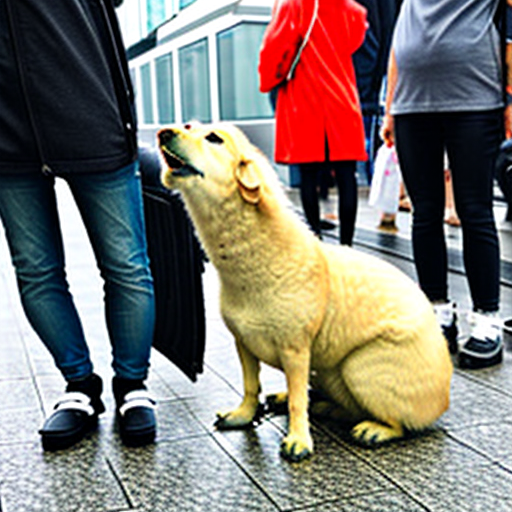

In [44]:
#@title ７．画像生成

#@markdown 成功すれば以下に画像が表示されます。

#@markdown 上手くいかない場合はプロンプトを変えて何度か挑戦してみてください。

import torch
from torch import autocast
from diffusers import StableDiffusionPipeline
from IPython.display import display

batch_size = 4
prompt = prompt_str * batch_size

g_cuda = torch.Generator(device='cuda')
pipe = StableDiffusionPipeline.from_pretrained(OUTPUT_DIR, torch_dtype=torch.float16).to("cuda")

with autocast("cuda"), torch.no_grad():
    images = pipe(prompt, height=512, width=512, num_inference_steps=50, guidance_scale=7.5, generator=g_cuda).images

for img in images:
    display(img)